In [5]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random

In [6]:
# Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed
set_seed(42)

In [7]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Logistic

In [8]:
class LabeledImageDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0

        # Convert to a torch tensor and add channel dimension
        image = torch.tensor(image, dtype=torch.float32)
        
        # Apply resize transform
        image = self.resize_transform(image)

        label = self.labels[idx]

        return image, label

def load_and_split_data(root_dir, test_size=0.2):
    
    #classes = ['cond7_all', 'sd_only']
    classes = ['sd', 'ex_40']

    image_files = []
    labels = []

    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(root_dir, class_name)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        labels.extend([idx] * len(files))
    
    # Check if the labels correctly reflect the classes
    #print("Label distribution:", {classes[i]: labels.count(i) for i in range(len(classes))})
    
    # Split data into training and test sets
    train_files, test_files, train_labels, test_labels = train_test_split(
        image_files, labels, test_size=test_size, stratify=labels, random_state=42)

    return train_files, test_files, train_labels, test_labels


# Directories for labeled data
image_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\train_ex_vs_sd"

# Load and split the data
train_files, test_files, train_labels, test_labels = load_and_split_data(image_dir, test_size=0.2)

# Create the labeled datasets
train_labeled_dataset = LabeledImageDataset(train_files, train_labels)
test_labeled_dataset = LabeledImageDataset(test_files, test_labels)

# Define DataLoaders
batch_size = 16
train_loader_labeled = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0)
test_loader_labeled = DataLoader(test_labeled_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0)

In [9]:
for anchor,label in train_loader_labeled:
    print(anchor.shape, label.shape, anchor.dtype)
    print(label)
    break

torch.Size([16, 3, 96, 96]) torch.Size([16]) torch.float32
tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0])


In [10]:
def prepare_data_features(dataloader):
    feats, labels = [], []
    
    for batch_imgs, batch_labels in tqdm(dataloader):
        batch_imgs = batch_imgs.to(device)
        
        # Flatten the images from (N, C, H, W) to (N, C*H*W)
        batch_feats = batch_imgs.view(batch_imgs.size(0), -1)  # Flatten the images
        print(f"Batch features shape: {batch_feats.shape}")  # Check the feature shape
        print(f"Batch labels shape: {batch_labels.shape}")
        
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)
    
    print(f"Features shape after concatenation: {feats.shape}")
    print(f"Labels shape after concatenation: {labels.shape}")

    return torch.utils.data.TensorDataset(feats, labels)


In [11]:
# Extract features for train and test datasets
train_feats = prepare_data_features(train_loader_labeled)
test_feats = prepare_data_features(test_loader_labeled)

 12%|█▎        | 1/8 [00:00<00:05,  1.19it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 25%|██▌       | 2/8 [00:01<00:04,  1.21it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 38%|███▊      | 3/8 [00:02<00:04,  1.22it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 50%|█████     | 4/8 [00:03<00:03,  1.22it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 62%|██████▎   | 5/8 [00:04<00:02,  1.23it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 75%|███████▌  | 6/8 [00:04<00:01,  1.22it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])
Batch features shape: torch.Size([2, 27648])
Batch labels shape: torch.Size([2])
Features shape after concatenation: torch.Size([114, 27648])
Labels shape after concatenation: torch.Size([114])


 50%|█████     | 1/2 [00:00<00:00,  1.20it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

Batch features shape: torch.Size([13, 27648])
Batch labels shape: torch.Size([13])
Features shape after concatenation: torch.Size([29, 27648])
Labels shape after concatenation: torch.Size([29])


In [12]:
# Logistic Regression model definition
class LogisticRegression(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.linear(x)

In [13]:
# Training function
def train_logistic_regression(model, train_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    for batch_feats, batch_labels in tqdm(train_loader, desc="Training"):
        batch_feats, batch_labels = batch_feats.to(device), batch_labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_feats)
        loss = nn.functional.cross_entropy(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        
        # Update learning rate scheduler
        scheduler.step()

        total_loss += loss.item()

        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

In [14]:
# Evaluation function
def evaluate_logistic_regression(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_feats, batch_labels in tqdm(test_loader, desc="Evaluating"):
            batch_feats, batch_labels = batch_feats.to(device), batch_labels.to(device)
            
            outputs = model(batch_feats)
            loss = nn.functional.cross_entropy(outputs, batch_labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

In [15]:
def train_logreg_simplified(batch_size, train_feats_data, test_feats_data, feature_dim, num_classes, lr=5e-4, weight_decay=1e-4, max_epochs=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Data loaders
    train_loader = DataLoader(train_feats_data, batch_size=batch_size, shuffle=True,
                              drop_last=False, pin_memory=True, num_workers=0)
    test_loader = DataLoader(test_feats_data, batch_size=batch_size, shuffle=False,
                             drop_last=False, pin_memory=True, num_workers=0)

    # Model, loss, and optimizer
    model = LogisticRegression(feature_dim, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                               milestones=[int(max_epochs * 0.6), int(max_epochs * 0.8)],
                                               gamma=0.1)

    # Store metrics for plotting
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    # Track best by accuracy
    best_test_acc = -1.0
    best_model_state_acc = None

    # Track best by loss (with accuracy as a tiebreaker)
    best_test_loss = float('inf')
    best_test_loss_acc = -1.0
    best_model_state_loss = None

    for epoch in range(max_epochs):
        print(f"Epoch {epoch+1}/{max_epochs}")

        train_loss, train_acc = train_logistic_regression(model, train_loader, optimizer, scheduler, device)
        test_loss, test_acc = evaluate_logistic_regression(model, test_loader, criterion, device)

        print(f"Training loss: {train_loss:.4f}, Training accuracy: {train_acc:.4f}")
        print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        # Check for best accuracy model
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_model_state_acc = model.state_dict()

        # Check for best loss model
        # Condition: strictly lower loss OR equal loss but higher accuracy
        if (test_loss < best_test_loss) or (test_loss == best_test_loss and test_acc > best_test_loss_acc):
            best_test_loss = test_loss
            best_test_loss_acc = test_acc
            best_model_state_loss = model.state_dict()

    # Now we have two best states: best_model_state_acc and best_model_state_loss
    # Create two separate model instances for them
    best_acc_model = LogisticRegression(feature_dim, num_classes).to(device)
    best_acc_model.load_state_dict(best_model_state_acc)
    best_acc_model.eval()

    best_loss_model = LogisticRegression(feature_dim, num_classes).to(device)
    best_loss_model.load_state_dict(best_model_state_loss)
    best_loss_model.eval()

    # Plot results
    plt.figure(figsize=(15, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(range(max_epochs), train_losses, label='Train Loss')
    plt.plot(range(max_epochs), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(range(max_epochs), train_accuracies, label='Train Accuracy')
    plt.plot(range(max_epochs), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Return both models and the final results (e.g., last train_acc and test_acc recorded)
    return best_acc_model, best_loss_model, {"train_acc": train_acc, "test_acc": test_acc}


Epoch 1/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 2.8166, Training accuracy: 0.4123
Test loss: 3.4628, Test accuracy: 0.7241
Epoch 2/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 64.00it/s]


Training loss: 2.6664, Training accuracy: 0.7193
Test loss: 0.6024, Test accuracy: 0.6552
Epoch 3/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 59.44it/s]


Training loss: 1.0568, Training accuracy: 0.5175
Test loss: 0.4523, Test accuracy: 0.8621
Epoch 4/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.5753, Training accuracy: 0.8421
Test loss: 1.0718, Test accuracy: 0.7241
Epoch 5/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.9273, Training accuracy: 0.7193
Test loss: 0.3809, Test accuracy: 0.8621
Epoch 6/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.5511, Training accuracy: 0.6579
Test loss: 0.5738, Test accuracy: 0.7241
Epoch 7/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 53.90it/s]


Training loss: 0.5010, Training accuracy: 0.6491
Test loss: 0.5083, Test accuracy: 0.8621
Epoch 8/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.4658, Training accuracy: 0.8070
Test loss: 0.4287, Test accuracy: 0.8621
Epoch 9/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 127.49it/s]


Training loss: 0.3120, Training accuracy: 0.8947
Test loss: 0.3795, Test accuracy: 0.8621
Epoch 10/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.3803, Training accuracy: 0.8421
Test loss: 0.3219, Test accuracy: 0.8621
Epoch 11/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 63.76it/s]


Training loss: 0.2780, Training accuracy: 0.9035
Test loss: 0.4564, Test accuracy: 0.8621
Epoch 12/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 57.97it/s]


Training loss: 0.3294, Training accuracy: 0.8684
Test loss: 0.3623, Test accuracy: 0.8966
Epoch 13/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.2459, Training accuracy: 0.9211
Test loss: 0.3340, Test accuracy: 0.8276
Epoch 14/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.2832, Training accuracy: 0.8772
Test loss: 0.3220, Test accuracy: 0.8621
Epoch 15/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 61.82it/s]


Training loss: 0.2256, Training accuracy: 0.9298
Test loss: 0.3906, Test accuracy: 0.8966
Epoch 16/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 59.57it/s]


Training loss: 0.2677, Training accuracy: 0.9123
Test loss: 0.3687, Test accuracy: 0.8966
Epoch 17/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.2325, Training accuracy: 0.9211
Test loss: 0.3184, Test accuracy: 0.8621
Epoch 18/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 60.26it/s]


Training loss: 0.2853, Training accuracy: 0.8596
Test loss: 0.3170, Test accuracy: 0.8621
Epoch 19/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.2093, Training accuracy: 0.9123
Test loss: 0.4021, Test accuracy: 0.8966
Epoch 20/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.2510, Training accuracy: 0.9123
Test loss: 0.3870, Test accuracy: 0.8966
Epoch 21/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.2172, Training accuracy: 0.9211
Test loss: 0.3120, Test accuracy: 0.8621
Epoch 22/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 59.75it/s]


Training loss: 0.2240, Training accuracy: 0.9386
Test loss: 0.3094, Test accuracy: 0.8621
Epoch 23/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.2245, Training accuracy: 0.9211
Test loss: 0.3522, Test accuracy: 0.8966
Epoch 24/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 66.31it/s]


Training loss: 0.2165, Training accuracy: 0.9386
Test loss: 0.3513, Test accuracy: 0.8966
Epoch 25/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 57.84it/s]


Training loss: 0.1990, Training accuracy: 0.9211
Test loss: 0.3042, Test accuracy: 0.8621
Epoch 26/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.2140, Training accuracy: 0.9298
Test loss: 0.3011, Test accuracy: 0.8621
Epoch 27/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1970, Training accuracy: 0.9386
Test loss: 0.3420, Test accuracy: 0.8966
Epoch 28/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 63.78it/s]


Training loss: 0.2408, Training accuracy: 0.9386
Test loss: 0.3432, Test accuracy: 0.8966
Epoch 29/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 59.82it/s]


Training loss: 0.1994, Training accuracy: 0.9211
Test loss: 0.2914, Test accuracy: 0.8621
Epoch 30/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 54.18it/s]


Training loss: 0.2052, Training accuracy: 0.9386
Test loss: 0.3021, Test accuracy: 0.8621
Epoch 31/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.2054, Training accuracy: 0.9211
Test loss: 0.3766, Test accuracy: 0.8966
Epoch 32/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.2142, Training accuracy: 0.9298
Test loss: 0.3018, Test accuracy: 0.8621
Epoch 33/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1783, Training accuracy: 0.9211
Test loss: 0.2826, Test accuracy: 0.8621
Epoch 34/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 59.27it/s]


Training loss: 0.2047, Training accuracy: 0.9386
Test loss: 0.2949, Test accuracy: 0.8621
Epoch 35/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1723, Training accuracy: 0.9211
Test loss: 0.3675, Test accuracy: 0.8966
Epoch 36/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 64.00it/s]


Training loss: 0.2045, Training accuracy: 0.9298
Test loss: 0.2989, Test accuracy: 0.8966
Epoch 37/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 70.96it/s]


Training loss: 0.1761, Training accuracy: 0.9386
Test loss: 0.2730, Test accuracy: 0.8621
Epoch 38/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1914, Training accuracy: 0.9386
Test loss: 0.2924, Test accuracy: 0.8966
Epoch 39/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1668, Training accuracy: 0.9386
Test loss: 0.3125, Test accuracy: 0.8966
Epoch 40/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 57.81it/s]


Training loss: 0.1736, Training accuracy: 0.9386
Test loss: 0.2881, Test accuracy: 0.8966
Epoch 41/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1676, Training accuracy: 0.9298
Test loss: 0.2635, Test accuracy: 0.8621
Epoch 42/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1686, Training accuracy: 0.9298
Test loss: 0.2850, Test accuracy: 0.8966
Epoch 43/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 60.22it/s]


Training loss: 0.1568, Training accuracy: 0.9298
Test loss: 0.3024, Test accuracy: 0.8966
Epoch 44/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 60.57it/s]


Training loss: 0.1604, Training accuracy: 0.9474
Test loss: 0.2672, Test accuracy: 0.8621
Epoch 45/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1566, Training accuracy: 0.9386
Test loss: 0.2589, Test accuracy: 0.8621
Epoch 46/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1584, Training accuracy: 0.9298
Test loss: 0.2711, Test accuracy: 0.8966
Epoch 47/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 55.91it/s]


Training loss: 0.1505, Training accuracy: 0.9386
Test loss: 0.2736, Test accuracy: 0.8966
Epoch 48/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 246.90it/s]


Training loss: 0.1558, Training accuracy: 0.9386
Test loss: 0.2620, Test accuracy: 0.8966
Epoch 49/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1442, Training accuracy: 0.9386
Test loss: 0.2774, Test accuracy: 0.8966
Epoch 50/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 55.88it/s]


Training loss: 0.1621, Training accuracy: 0.9298
Test loss: 0.2799, Test accuracy: 0.8966
Epoch 51/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 57.12it/s]


Training loss: 0.1565, Training accuracy: 0.9386
Test loss: 0.2457, Test accuracy: 0.8621
Epoch 52/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 109.38it/s]


Training loss: 0.1526, Training accuracy: 0.9474
Test loss: 0.2721, Test accuracy: 0.8966
Epoch 53/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 105.20it/s]


Training loss: 0.1686, Training accuracy: 0.9474
Test loss: 0.2855, Test accuracy: 0.8966
Epoch 54/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 63.78it/s]


Training loss: 0.1498, Training accuracy: 0.9386
Test loss: 0.2420, Test accuracy: 0.8621
Epoch 55/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 52.33it/s]


Training loss: 0.1513, Training accuracy: 0.9561
Test loss: 0.2591, Test accuracy: 0.8966
Epoch 56/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 166.70it/s]


Training loss: 0.1418, Training accuracy: 0.9474
Test loss: 0.2943, Test accuracy: 0.8966
Epoch 57/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 200.04it/s]


Training loss: 0.1513, Training accuracy: 0.9386
Test loss: 0.2454, Test accuracy: 0.8966
Epoch 58/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1414, Training accuracy: 0.9474
Test loss: 0.2485, Test accuracy: 0.8966
Epoch 59/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 90.92it/s]


Training loss: 0.1401, Training accuracy: 0.9474
Test loss: 0.2555, Test accuracy: 0.8966
Epoch 60/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1358, Training accuracy: 0.9474
Test loss: 0.2795, Test accuracy: 0.8966
Epoch 61/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 75.17it/s]


Training loss: 0.1407, Training accuracy: 0.9474
Test loss: 0.2435, Test accuracy: 0.8966
Epoch 62/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1383, Training accuracy: 0.9474
Test loss: 0.2389, Test accuracy: 0.8966
Epoch 63/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1380, Training accuracy: 0.9386
Test loss: 0.2647, Test accuracy: 0.8966
Epoch 64/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 60.53it/s]


Training loss: 0.1302, Training accuracy: 0.9474
Test loss: 0.2393, Test accuracy: 0.8966
Epoch 65/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 60.00it/s]


Training loss: 0.1313, Training accuracy: 0.9474
Test loss: 0.2458, Test accuracy: 0.8966
Epoch 66/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1277, Training accuracy: 0.9561
Test loss: 0.2534, Test accuracy: 0.8966
Epoch 67/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1322, Training accuracy: 0.9474
Test loss: 0.2427, Test accuracy: 0.8966
Epoch 68/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 62.19it/s]


Training loss: 0.1325, Training accuracy: 0.9474
Test loss: 0.2433, Test accuracy: 0.8966
Epoch 69/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 235.53it/s]


Training loss: 0.1209, Training accuracy: 0.9561
Test loss: 0.2331, Test accuracy: 0.8966
Epoch 70/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 154.70it/s]


Training loss: 0.1272, Training accuracy: 0.9561
Test loss: 0.2495, Test accuracy: 0.8966
Epoch 71/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 712.95it/s]


Training loss: 0.1195, Training accuracy: 0.9561
Test loss: 0.2500, Test accuracy: 0.8966
Epoch 72/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 185.91it/s]


Training loss: 0.1316, Training accuracy: 0.9561
Test loss: 0.2425, Test accuracy: 0.8966
Epoch 73/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 130.43it/s]


Training loss: 0.1359, Training accuracy: 0.9474
Test loss: 0.2325, Test accuracy: 0.8966
Epoch 74/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1173, Training accuracy: 0.9561
Test loss: 0.2687, Test accuracy: 0.8966
Epoch 75/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 59.94it/s]


Training loss: 0.1552, Training accuracy: 0.9386
Test loss: 0.2478, Test accuracy: 0.8966
Epoch 76/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 45.72it/s]


Training loss: 0.1165, Training accuracy: 0.9561
Test loss: 0.2400, Test accuracy: 0.8966
Epoch 77/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 375.36it/s]


Training loss: 0.1153, Training accuracy: 0.9561
Test loss: 0.2338, Test accuracy: 0.8966
Epoch 78/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 58.49it/s]


Training loss: 0.1232, Training accuracy: 0.9474
Test loss: 0.2321, Test accuracy: 0.8966
Epoch 79/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 200.06it/s]


Training loss: 0.1124, Training accuracy: 0.9474
Test loss: 0.2313, Test accuracy: 0.8966
Epoch 80/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 70.83it/s]


Training loss: 0.1173, Training accuracy: 0.9561
Test loss: 0.2331, Test accuracy: 0.8966
Epoch 81/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1136, Training accuracy: 0.9474
Test loss: 0.2370, Test accuracy: 0.8966
Epoch 82/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 58.21it/s]


Training loss: 0.1227, Training accuracy: 0.9561
Test loss: 0.2419, Test accuracy: 0.8966
Epoch 83/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1192, Training accuracy: 0.9561
Test loss: 0.2450, Test accuracy: 0.8966
Epoch 84/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1208, Training accuracy: 0.9561
Test loss: 0.2447, Test accuracy: 0.8966
Epoch 85/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 60.13it/s]


Training loss: 0.1176, Training accuracy: 0.9561
Test loss: 0.2429, Test accuracy: 0.8966
Epoch 86/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1200, Training accuracy: 0.9561
Test loss: 0.2408, Test accuracy: 0.8966
Epoch 87/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 68.08it/s]


Training loss: 0.1269, Training accuracy: 0.9561
Test loss: 0.2397, Test accuracy: 0.8966
Epoch 88/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 65.76it/s]


Training loss: 0.1205, Training accuracy: 0.9561
Test loss: 0.2353, Test accuracy: 0.8966
Epoch 89/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 53.29it/s]


Training loss: 0.1191, Training accuracy: 0.9561
Test loss: 0.2334, Test accuracy: 0.8966
Epoch 90/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 64.00it/s]


Training loss: 0.1162, Training accuracy: 0.9474
Test loss: 0.2327, Test accuracy: 0.8966
Epoch 91/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1190, Training accuracy: 0.9474
Test loss: 0.2338, Test accuracy: 0.8966
Epoch 92/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1166, Training accuracy: 0.9561
Test loss: 0.2369, Test accuracy: 0.8966
Epoch 93/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1145, Training accuracy: 0.9561
Test loss: 0.2407, Test accuracy: 0.8966
Epoch 94/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 59.76it/s]


Training loss: 0.1162, Training accuracy: 0.9561
Test loss: 0.2454, Test accuracy: 0.8966
Epoch 95/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1227, Training accuracy: 0.9561
Test loss: 0.2480, Test accuracy: 0.8966
Epoch 96/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 59.09it/s]


Training loss: 0.1141, Training accuracy: 0.9561
Test loss: 0.2431, Test accuracy: 0.8966
Epoch 97/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1169, Training accuracy: 0.9561
Test loss: 0.2402, Test accuracy: 0.8966
Epoch 98/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1157, Training accuracy: 0.9561
Test loss: 0.2366, Test accuracy: 0.8966
Epoch 99/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1216, Training accuracy: 0.9561
Test loss: 0.2357, Test accuracy: 0.8966
Epoch 100/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1184, Training accuracy: 0.9561
Test loss: 0.2342, Test accuracy: 0.8966
Epoch 101/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 74.62it/s]


Training loss: 0.1133, Training accuracy: 0.9561
Test loss: 0.2340, Test accuracy: 0.8966
Epoch 102/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 123.04it/s]


Training loss: 0.1185, Training accuracy: 0.9561
Test loss: 0.2342, Test accuracy: 0.8966
Epoch 103/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 58.94it/s]


Training loss: 0.1154, Training accuracy: 0.9561
Test loss: 0.2344, Test accuracy: 0.8966
Epoch 104/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1133, Training accuracy: 0.9561
Test loss: 0.2346, Test accuracy: 0.8966
Epoch 105/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 68.20it/s]


Training loss: 0.1142, Training accuracy: 0.9561
Test loss: 0.2349, Test accuracy: 0.8966
Epoch 106/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1133, Training accuracy: 0.9561
Test loss: 0.2354, Test accuracy: 0.8966
Epoch 107/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 59.80it/s]


Training loss: 0.1137, Training accuracy: 0.9561
Test loss: 0.2358, Test accuracy: 0.8966
Epoch 108/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 53.75it/s]


Training loss: 0.1138, Training accuracy: 0.9561
Test loss: 0.2364, Test accuracy: 0.8966
Epoch 109/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 200.05it/s]


Training loss: 0.1184, Training accuracy: 0.9561
Test loss: 0.2370, Test accuracy: 0.8966
Epoch 110/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 61.55it/s]


Training loss: 0.1147, Training accuracy: 0.9561
Test loss: 0.2375, Test accuracy: 0.8966
Epoch 111/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1171, Training accuracy: 0.9561
Test loss: 0.2379, Test accuracy: 0.8966
Epoch 112/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 64.00it/s]


Training loss: 0.1186, Training accuracy: 0.9561
Test loss: 0.2383, Test accuracy: 0.8966
Epoch 113/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 58.00it/s]


Training loss: 0.1135, Training accuracy: 0.9561
Test loss: 0.2384, Test accuracy: 0.8966
Epoch 114/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1201, Training accuracy: 0.9561
Test loss: 0.2386, Test accuracy: 0.8966
Epoch 115/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1166, Training accuracy: 0.9561
Test loss: 0.2387, Test accuracy: 0.8966
Epoch 116/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 61.51it/s]


Training loss: 0.1180, Training accuracy: 0.9561
Test loss: 0.2388, Test accuracy: 0.8966
Epoch 117/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 59.65it/s]


Training loss: 0.1151, Training accuracy: 0.9561
Test loss: 0.2387, Test accuracy: 0.8966
Epoch 118/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1141, Training accuracy: 0.9561
Test loss: 0.2387, Test accuracy: 0.8966
Epoch 119/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1146, Training accuracy: 0.9561
Test loss: 0.2386, Test accuracy: 0.8966
Epoch 120/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1137, Training accuracy: 0.9561
Test loss: 0.2385, Test accuracy: 0.8966
Epoch 121/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 70.35it/s]


Training loss: 0.1122, Training accuracy: 0.9561
Test loss: 0.2383, Test accuracy: 0.8966
Epoch 122/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 769.03it/s]


Training loss: 0.1097, Training accuracy: 0.9561
Test loss: 0.2381, Test accuracy: 0.8966
Epoch 123/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1193, Training accuracy: 0.9561
Test loss: 0.2382, Test accuracy: 0.8966
Epoch 124/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1174, Training accuracy: 0.9561
Test loss: 0.2382, Test accuracy: 0.8966
Epoch 125/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 251.50it/s]


Training loss: 0.1191, Training accuracy: 0.9561
Test loss: 0.2381, Test accuracy: 0.8966
Epoch 126/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 125.01it/s]


Training loss: 0.1160, Training accuracy: 0.9561
Test loss: 0.2378, Test accuracy: 0.8966
Epoch 127/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s]


Training loss: 0.1155, Training accuracy: 0.9561
Test loss: 0.2376, Test accuracy: 0.8966
Epoch 128/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 166.68it/s]


Training loss: 0.1122, Training accuracy: 0.9561
Test loss: 0.2373, Test accuracy: 0.8966
Epoch 129/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 250.02it/s]


Training loss: 0.1161, Training accuracy: 0.9561
Test loss: 0.2372, Test accuracy: 0.8966
Epoch 130/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 250.08it/s]


Training loss: 0.1152, Training accuracy: 0.9561
Test loss: 0.2373, Test accuracy: 0.8966
Epoch 131/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 141.35it/s]


Training loss: 0.1140, Training accuracy: 0.9561
Test loss: 0.2376, Test accuracy: 0.8966
Epoch 132/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 60.32it/s]


Training loss: 0.1154, Training accuracy: 0.9561
Test loss: 0.2377, Test accuracy: 0.8966
Epoch 133/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 476.79it/s]


Training loss: 0.1153, Training accuracy: 0.9561
Test loss: 0.2378, Test accuracy: 0.8966
Epoch 134/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 55.70it/s]


Training loss: 0.1170, Training accuracy: 0.9561
Test loss: 0.2378, Test accuracy: 0.8966
Epoch 135/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 66.05it/s]


Training loss: 0.1187, Training accuracy: 0.9561
Test loss: 0.2377, Test accuracy: 0.8966
Epoch 136/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1126, Training accuracy: 0.9561
Test loss: 0.2376, Test accuracy: 0.8966
Epoch 137/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 383.85it/s]


Training loss: 0.1160, Training accuracy: 0.9561
Test loss: 0.2376, Test accuracy: 0.8966
Epoch 138/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 58.07it/s]


Training loss: 0.1166, Training accuracy: 0.9561
Test loss: 0.2375, Test accuracy: 0.8966
Epoch 139/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 58.09it/s]


Training loss: 0.1197, Training accuracy: 0.9561
Test loss: 0.2375, Test accuracy: 0.8966
Epoch 140/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1133, Training accuracy: 0.9561
Test loss: 0.2374, Test accuracy: 0.8966
Epoch 141/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 66.80it/s]


Training loss: 0.1154, Training accuracy: 0.9561
Test loss: 0.2373, Test accuracy: 0.8966
Epoch 142/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 210.15it/s]


Training loss: 0.1181, Training accuracy: 0.9561
Test loss: 0.2374, Test accuracy: 0.8966
Epoch 143/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 224.08it/s]


Training loss: 0.1155, Training accuracy: 0.9561
Test loss: 0.2374, Test accuracy: 0.8966
Epoch 144/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1157, Training accuracy: 0.9561
Test loss: 0.2375, Test accuracy: 0.8966
Epoch 145/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 86.98it/s]


Training loss: 0.1151, Training accuracy: 0.9561
Test loss: 0.2375, Test accuracy: 0.8966
Epoch 146/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 62.08it/s]


Training loss: 0.1189, Training accuracy: 0.9561
Test loss: 0.2377, Test accuracy: 0.8966
Epoch 147/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 246.72it/s]


Training loss: 0.1148, Training accuracy: 0.9561
Test loss: 0.2375, Test accuracy: 0.8966
Epoch 148/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 77.94it/s]


Training loss: 0.1205, Training accuracy: 0.9561
Test loss: 0.2375, Test accuracy: 0.8966
Epoch 149/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 297.62it/s]


Training loss: 0.1124, Training accuracy: 0.9561
Test loss: 0.2375, Test accuracy: 0.8966
Epoch 150/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1171, Training accuracy: 0.9561
Test loss: 0.2376, Test accuracy: 0.8966
Epoch 151/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 87.48it/s]


Training loss: 0.1161, Training accuracy: 0.9561
Test loss: 0.2373, Test accuracy: 0.8966
Epoch 152/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 77.62it/s]


Training loss: 0.1185, Training accuracy: 0.9561
Test loss: 0.2374, Test accuracy: 0.8966
Epoch 153/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 222.34it/s]


Training loss: 0.1140, Training accuracy: 0.9561
Test loss: 0.2372, Test accuracy: 0.8966
Epoch 154/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1133, Training accuracy: 0.9561
Test loss: 0.2372, Test accuracy: 0.8966
Epoch 155/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 69.98it/s]


Training loss: 0.1181, Training accuracy: 0.9561
Test loss: 0.2373, Test accuracy: 0.8966
Epoch 156/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 169.33it/s]


Training loss: 0.1242, Training accuracy: 0.9561
Test loss: 0.2373, Test accuracy: 0.8966
Epoch 157/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 2242.94it/s]


Training loss: 0.1125, Training accuracy: 0.9561
Test loss: 0.2369, Test accuracy: 0.8966
Epoch 158/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 96.79it/s]


Training loss: 0.1121, Training accuracy: 0.9561
Test loss: 0.2368, Test accuracy: 0.8966
Epoch 159/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 330.62it/s]


Training loss: 0.1136, Training accuracy: 0.9561
Test loss: 0.2370, Test accuracy: 0.8966
Epoch 160/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 57.50it/s]


Training loss: 0.1213, Training accuracy: 0.9561
Test loss: 0.2371, Test accuracy: 0.8966
Epoch 161/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 996.98it/s]


Training loss: 0.1184, Training accuracy: 0.9561
Test loss: 0.2371, Test accuracy: 0.8966
Epoch 162/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 70.04it/s]


Training loss: 0.1161, Training accuracy: 0.9561
Test loss: 0.2370, Test accuracy: 0.8966
Epoch 163/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 214.48it/s]


Training loss: 0.1185, Training accuracy: 0.9561
Test loss: 0.2368, Test accuracy: 0.8966
Epoch 164/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1151, Training accuracy: 0.9561
Test loss: 0.2366, Test accuracy: 0.8966
Epoch 165/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1106, Training accuracy: 0.9561
Test loss: 0.2366, Test accuracy: 0.8966
Epoch 166/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 87.44it/s]


Training loss: 0.1126, Training accuracy: 0.9561
Test loss: 0.2366, Test accuracy: 0.8966
Epoch 167/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 74.02it/s]


Training loss: 0.1145, Training accuracy: 0.9561
Test loss: 0.2366, Test accuracy: 0.8966
Epoch 168/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 195.44it/s]


Training loss: 0.1221, Training accuracy: 0.9561
Test loss: 0.2369, Test accuracy: 0.8966
Epoch 169/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 197.41it/s]


Training loss: 0.1125, Training accuracy: 0.9561
Test loss: 0.2368, Test accuracy: 0.8966
Epoch 170/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1150, Training accuracy: 0.9561
Test loss: 0.2367, Test accuracy: 0.8966
Epoch 171/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 86.30it/s]


Training loss: 0.1206, Training accuracy: 0.9561
Test loss: 0.2369, Test accuracy: 0.8966
Epoch 172/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 300.67it/s]


Training loss: 0.1195, Training accuracy: 0.9561
Test loss: 0.2368, Test accuracy: 0.8966
Epoch 173/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 200.06it/s]


Training loss: 0.1219, Training accuracy: 0.9561
Test loss: 0.2370, Test accuracy: 0.8966
Epoch 174/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1219, Training accuracy: 0.9561
Test loss: 0.2370, Test accuracy: 0.8966
Epoch 175/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 145.86it/s]


Training loss: 0.1146, Training accuracy: 0.9561
Test loss: 0.2366, Test accuracy: 0.8966
Epoch 176/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 78.27it/s]


Training loss: 0.1161, Training accuracy: 0.9561
Test loss: 0.2361, Test accuracy: 0.8966
Epoch 177/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 219.25it/s]


Training loss: 0.1201, Training accuracy: 0.9561
Test loss: 0.2361, Test accuracy: 0.8966
Epoch 178/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 306.00it/s]


Training loss: 0.1158, Training accuracy: 0.9561
Test loss: 0.2361, Test accuracy: 0.8966
Epoch 179/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 383.43it/s]


Training loss: 0.1177, Training accuracy: 0.9561
Test loss: 0.2361, Test accuracy: 0.8966
Epoch 180/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1194, Training accuracy: 0.9561
Test loss: 0.2362, Test accuracy: 0.8966
Epoch 181/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1144, Training accuracy: 0.9561
Test loss: 0.2362, Test accuracy: 0.8966
Epoch 182/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 76.98it/s]


Training loss: 0.1153, Training accuracy: 0.9561
Test loss: 0.2363, Test accuracy: 0.8966
Epoch 183/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 213.96it/s]


Training loss: 0.1128, Training accuracy: 0.9561
Test loss: 0.2366, Test accuracy: 0.8966
Epoch 184/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1104, Training accuracy: 0.9561
Test loss: 0.2369, Test accuracy: 0.8966
Epoch 185/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1182, Training accuracy: 0.9561
Test loss: 0.2374, Test accuracy: 0.8966
Epoch 186/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 78.97it/s]


Training loss: 0.1127, Training accuracy: 0.9561
Test loss: 0.2377, Test accuracy: 0.8966
Epoch 187/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1116, Training accuracy: 0.9561
Test loss: 0.2379, Test accuracy: 0.8966
Epoch 188/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1153, Training accuracy: 0.9561
Test loss: 0.2382, Test accuracy: 0.8966
Epoch 189/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 69.83it/s]


Training loss: 0.1182, Training accuracy: 0.9561
Test loss: 0.2386, Test accuracy: 0.8966
Epoch 190/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 88.88it/s]


Training loss: 0.1116, Training accuracy: 0.9561
Test loss: 0.2386, Test accuracy: 0.8966
Epoch 191/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 688.15it/s]


Training loss: 0.1131, Training accuracy: 0.9561
Test loss: 0.2388, Test accuracy: 0.8966
Epoch 192/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1136, Training accuracy: 0.9561
Test loss: 0.2387, Test accuracy: 0.8966
Epoch 193/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 68.09it/s]


Training loss: 0.1104, Training accuracy: 0.9561
Test loss: 0.2387, Test accuracy: 0.8966
Epoch 194/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 226.18it/s]


Training loss: 0.1168, Training accuracy: 0.9561
Test loss: 0.2389, Test accuracy: 0.8966
Epoch 195/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 322.12it/s]


Training loss: 0.1179, Training accuracy: 0.9561
Test loss: 0.2390, Test accuracy: 0.8966
Epoch 196/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 105.83it/s]


Training loss: 0.1194, Training accuracy: 0.9561
Test loss: 0.2387, Test accuracy: 0.8966
Epoch 197/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 74.79it/s]


Training loss: 0.1141, Training accuracy: 0.9561
Test loss: 0.2383, Test accuracy: 0.8966
Epoch 198/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 243.02it/s]


Training loss: 0.1154, Training accuracy: 0.9561
Test loss: 0.2378, Test accuracy: 0.8966
Epoch 199/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 264.14it/s]


Training loss: 0.1207, Training accuracy: 0.9561
Test loss: 0.2377, Test accuracy: 0.8966
Epoch 200/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 75.49it/s]


Training loss: 0.1164, Training accuracy: 0.9561
Test loss: 0.2373, Test accuracy: 0.8966
Epoch 201/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 134.84it/s]


Training loss: 0.1103, Training accuracy: 0.9561
Test loss: 0.2368, Test accuracy: 0.8966
Epoch 202/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 597.82it/s]


Training loss: 0.1140, Training accuracy: 0.9561
Test loss: 0.2363, Test accuracy: 0.8966
Epoch 203/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 60.38it/s]


Training loss: 0.1146, Training accuracy: 0.9561
Test loss: 0.2360, Test accuracy: 0.8966
Epoch 204/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1120, Training accuracy: 0.9561
Test loss: 0.2359, Test accuracy: 0.8966
Epoch 205/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 75.02it/s]


Training loss: 0.1108, Training accuracy: 0.9561
Test loss: 0.2358, Test accuracy: 0.8966
Epoch 206/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 75.11it/s]


Training loss: 0.1141, Training accuracy: 0.9561
Test loss: 0.2358, Test accuracy: 0.8966
Epoch 207/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 56.83it/s]


Training loss: 0.1164, Training accuracy: 0.9561
Test loss: 0.2361, Test accuracy: 0.8966
Epoch 208/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 166.73it/s]


Training loss: 0.1130, Training accuracy: 0.9561
Test loss: 0.2363, Test accuracy: 0.8966
Epoch 209/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 296.96it/s]


Training loss: 0.1115, Training accuracy: 0.9561
Test loss: 0.2363, Test accuracy: 0.8966
Epoch 210/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 166.69it/s]


Training loss: 0.1183, Training accuracy: 0.9561
Test loss: 0.2369, Test accuracy: 0.8966
Epoch 211/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 58.89it/s]


Training loss: 0.1121, Training accuracy: 0.9561
Test loss: 0.2373, Test accuracy: 0.8966
Epoch 212/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 76.98it/s]


Training loss: 0.1121, Training accuracy: 0.9561
Test loss: 0.2377, Test accuracy: 0.8966
Epoch 213/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 80.43it/s]


Training loss: 0.1192, Training accuracy: 0.9561
Test loss: 0.2380, Test accuracy: 0.8966
Epoch 214/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1202, Training accuracy: 0.9561
Test loss: 0.2380, Test accuracy: 0.8966
Epoch 215/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 75.63it/s]


Training loss: 0.1137, Training accuracy: 0.9561
Test loss: 0.2377, Test accuracy: 0.8966
Epoch 216/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 77.08it/s]


Training loss: 0.1119, Training accuracy: 0.9561
Test loss: 0.2375, Test accuracy: 0.8966
Epoch 217/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1159, Training accuracy: 0.9561
Test loss: 0.2374, Test accuracy: 0.8966
Epoch 218/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 80.01it/s]


Training loss: 0.1159, Training accuracy: 0.9561
Test loss: 0.2375, Test accuracy: 0.8966
Epoch 219/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1136, Training accuracy: 0.9561
Test loss: 0.2375, Test accuracy: 0.8966
Epoch 220/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 288.45it/s]


Training loss: 0.1163, Training accuracy: 0.9561
Test loss: 0.2373, Test accuracy: 0.8966
Epoch 221/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 198.19it/s]


Training loss: 0.1145, Training accuracy: 0.9561
Test loss: 0.2373, Test accuracy: 0.8966
Epoch 222/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 62.01it/s]


Training loss: 0.1127, Training accuracy: 0.9561
Test loss: 0.2371, Test accuracy: 0.8966
Epoch 223/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 57.46it/s]


Training loss: 0.1117, Training accuracy: 0.9561
Test loss: 0.2369, Test accuracy: 0.8966
Epoch 224/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1086, Training accuracy: 0.9561
Test loss: 0.2368, Test accuracy: 0.8966
Epoch 225/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 58.72it/s]


Training loss: 0.1124, Training accuracy: 0.9561
Test loss: 0.2370, Test accuracy: 0.8966
Epoch 226/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1151, Training accuracy: 0.9561
Test loss: 0.2372, Test accuracy: 0.8966
Epoch 227/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 98.98it/s]


Training loss: 0.1189, Training accuracy: 0.9561
Test loss: 0.2374, Test accuracy: 0.8966
Epoch 228/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1154, Training accuracy: 0.9561
Test loss: 0.2374, Test accuracy: 0.8966
Epoch 229/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 107.98it/s]


Training loss: 0.1166, Training accuracy: 0.9561
Test loss: 0.2377, Test accuracy: 0.8966
Epoch 230/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 566.49it/s]


Training loss: 0.1146, Training accuracy: 0.9561
Test loss: 0.2376, Test accuracy: 0.8966
Epoch 231/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 67.22it/s]


Training loss: 0.1200, Training accuracy: 0.9561
Test loss: 0.2374, Test accuracy: 0.8966
Epoch 232/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1157, Training accuracy: 0.9561
Test loss: 0.2372, Test accuracy: 0.8966
Epoch 233/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 140.01it/s]


Training loss: 0.1146, Training accuracy: 0.9561
Test loss: 0.2368, Test accuracy: 0.8966
Epoch 234/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 153.65it/s]


Training loss: 0.1159, Training accuracy: 0.9561
Test loss: 0.2370, Test accuracy: 0.8966
Epoch 235/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 59.25it/s]


Training loss: 0.1120, Training accuracy: 0.9561
Test loss: 0.2369, Test accuracy: 0.8966
Epoch 236/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1090, Training accuracy: 0.9561
Test loss: 0.2366, Test accuracy: 0.8966
Epoch 237/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1191, Training accuracy: 0.9561
Test loss: 0.2368, Test accuracy: 0.8966
Epoch 238/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 153.85it/s]


Training loss: 0.1164, Training accuracy: 0.9561
Test loss: 0.2370, Test accuracy: 0.8966
Epoch 239/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 410.32it/s]


Training loss: 0.1134, Training accuracy: 0.9561
Test loss: 0.2368, Test accuracy: 0.8966
Epoch 240/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 74.90it/s]


Training loss: 0.1134, Training accuracy: 0.9561
Test loss: 0.2368, Test accuracy: 0.8966
Epoch 241/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 73.56it/s]


Training loss: 0.1159, Training accuracy: 0.9561
Test loss: 0.2369, Test accuracy: 0.8966
Epoch 242/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1190, Training accuracy: 0.9561
Test loss: 0.2369, Test accuracy: 0.8966
Epoch 243/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 52.68it/s]


Training loss: 0.1118, Training accuracy: 0.9561
Test loss: 0.2367, Test accuracy: 0.8966
Epoch 244/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1124, Training accuracy: 0.9561
Test loss: 0.2368, Test accuracy: 0.8966
Epoch 245/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 173.91it/s]


Training loss: 0.1212, Training accuracy: 0.9561
Test loss: 0.2370, Test accuracy: 0.8966
Epoch 246/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1104, Training accuracy: 0.9561
Test loss: 0.2368, Test accuracy: 0.8966
Epoch 247/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 63.70it/s]


Training loss: 0.1159, Training accuracy: 0.9561
Test loss: 0.2368, Test accuracy: 0.8966
Epoch 248/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]

Training loss: 0.1119, Training accuracy: 0.9561
Test loss: 0.2367, Test accuracy: 0.8966
Epoch 249/250



Evaluating: 100%|██████████| 1/1 [00:00<00:00, 158.01it/s]


Training loss: 0.1173, Training accuracy: 0.9561
Test loss: 0.2365, Test accuracy: 0.8966
Epoch 250/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 107.57it/s]


Training loss: 0.1136, Training accuracy: 0.9561
Test loss: 0.2364, Test accuracy: 0.8966


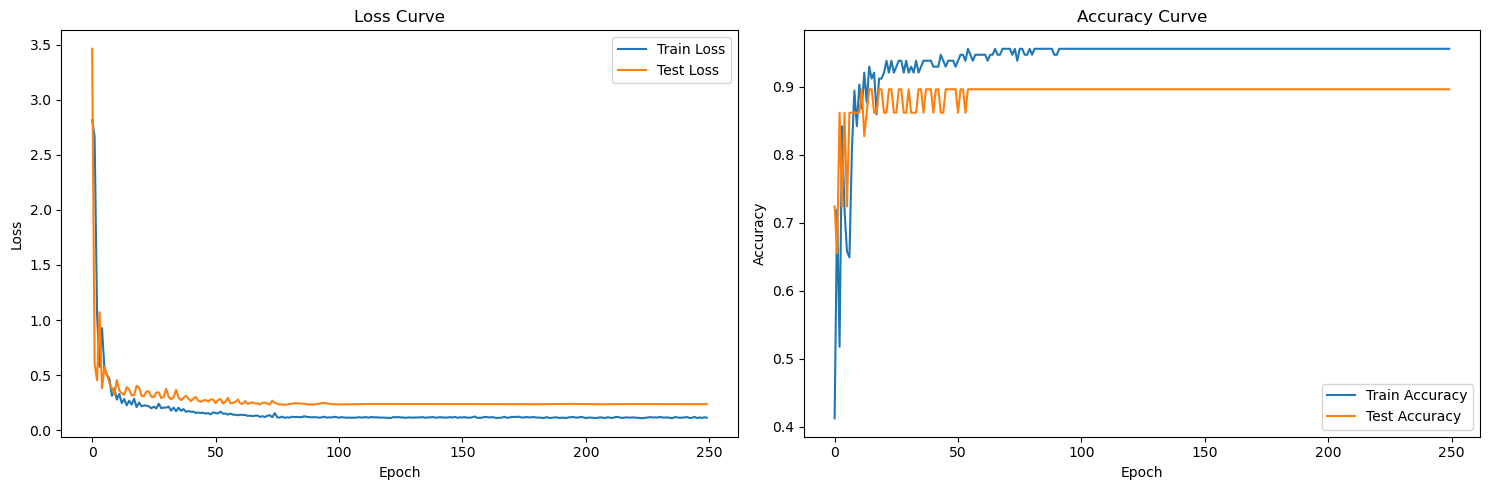

In [16]:
best_acc_model, best_loss_model, results = train_logreg_simplified(
    batch_size=64,
    train_feats_data=train_feats,
    test_feats_data=test_feats,
    feature_dim=train_feats.tensors[0].shape[1],
    num_classes=2,
    lr=5e-4,
    weight_decay=1e-4,
    max_epochs=250
)

In [17]:
logreg_model= best_loss_model
logreg_model
logreg_model.eval()  # This disables dropout and batchnorm for inference

LogisticRegression(
  (linear): Linear(in_features=27648, out_features=2, bias=True)
)

In [18]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path
    
def extract_features(dataloader):
    feats, labels, paths = [], [],[]

    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
    #for batch_imgs, batch_labels in tqdm(dataloader):
        batch_imgs = batch_imgs.to(device)
        
        # Flatten the images from (N, C, H, W) to (N, C*H*W)
        batch_feats = batch_imgs.view(batch_imgs.size(0), -1)  # Flatten the images

        print(f"Batch features shape: {batch_feats.shape}")  # Check the feature shape
        print(f"Batch labels shape: {batch_labels.shape}")
        
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)
        paths.extend(batch_paths)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)
    
    print(f"Features shape after concatenation: {feats.shape}")
    print(f"Labels shape after concatenation: {labels.shape}")

    return feats, labels, paths


In [19]:
root_dir = r"G:\softmax\inference"

In [20]:
# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

In [21]:
# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)

In [22]:
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

In [23]:
# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(inference_loader)

Extracting Features:   3%|▎         | 1/39 [00:07<04:39,  7.34s/it]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


Extracting Features:   5%|▌         | 2/39 [00:14<04:25,  7.19s/it]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


Extracting Features:   8%|▊         | 3/39 [00:21<04:18,  7.17s/it]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


Extracting Features:  10%|█         | 4/39 [00:28<04:10,  7.15s/it]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


Extracting Features:  13%|█▎        | 5/39 [00:35<04:02,  7.13s/it]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


Extracting Features:  15%|█▌        | 6/39 [00:42<03:54,  7.10s/it]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


Extracting Features:  18%|█▊        | 7/39 [00:50<03:48,  7.13s/it]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


Extracting Features:  21%|██        | 8/39 [00:57<03:41,  7.15s/it]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


Extracting Features:  23%|██▎       | 9/39 [01:04<03:34,  7.15s/it]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


Extracting Features:  26%|██▌       | 10/39 [01:11<03:26,  7.11s/it]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


Extracting Features:  28%|██▊       | 11/39 [01:18<03:19,  7.12s/it]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


Extracting Features:  31%|███       | 12/39 [01:25<03:12,  7.12s/it]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


Extracting Features:  33%|███▎      | 13/39 [01:32<03:05,  7.13s/it]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


Extracting Features:  36%|███▌      | 14/39 [01:39<02:58,  7.13s/it]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


Extracting Features:  38%|███▊      | 15/39 [01:47<02:51,  7.14s/it]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


Extracting Features:  41%|████      | 16/39 [01:53<02:39,  6.93s/it]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


Extracting Features:  44%|████▎     | 17/39 [01:59<02:29,  6.78s/it]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


Extracting Features:  46%|████▌     | 18/39 [02:06<02:20,  6.67s/it]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


Extracting Features:  49%|████▊     | 19/39 [02:12<02:11,  6.59s/it]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


Extracting Features:  51%|█████▏    | 20/39 [02:19<02:04,  6.53s/it]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


Extracting Features:  54%|█████▍    | 21/39 [02:25<01:57,  6.50s/it]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


Extracting Features:  56%|█████▋    | 22/39 [02:32<01:50,  6.48s/it]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


Extracting Features:  59%|█████▉    | 23/39 [02:38<01:43,  6.45s/it]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


Extracting Features:  62%|██████▏   | 24/39 [02:44<01:36,  6.43s/it]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


Extracting Features:  64%|██████▍   | 25/39 [02:51<01:30,  6.44s/it]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


Extracting Features:  67%|██████▋   | 26/39 [02:57<01:23,  6.42s/it]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


Extracting Features:  69%|██████▉   | 27/39 [03:04<01:17,  6.42s/it]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


Extracting Features:  72%|███████▏  | 28/39 [03:10<01:10,  6.40s/it]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


Extracting Features:  74%|███████▍  | 29/39 [03:16<01:03,  6.40s/it]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


Extracting Features:  77%|███████▋  | 30/39 [03:23<00:58,  6.51s/it]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


Extracting Features:  79%|███████▉  | 31/39 [03:30<00:53,  6.69s/it]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


Extracting Features:  82%|████████▏ | 32/39 [03:37<00:47,  6.82s/it]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


Extracting Features:  85%|████████▍ | 33/39 [03:44<00:41,  6.92s/it]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


Extracting Features:  87%|████████▋ | 34/39 [03:52<00:35,  7.03s/it]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


Extracting Features:  90%|████████▉ | 35/39 [03:59<00:28,  7.07s/it]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


Extracting Features:  92%|█████████▏| 36/39 [04:06<00:21,  7.09s/it]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


Extracting Features:  95%|█████████▍| 37/39 [04:13<00:14,  7.10s/it]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


Extracting Features:  97%|█████████▋| 38/39 [04:20<00:07,  7.14s/it]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


Extracting Features: 100%|██████████| 39/39 [04:23<00:00,  6.77s/it]

Batch features shape: torch.Size([7, 27648])
Batch labels shape: torch.Size([7])
Features shape after concatenation: torch.Size([615, 27648])
Labels shape after concatenation: torch.Size([615])


In [24]:
@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()


In [25]:
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]

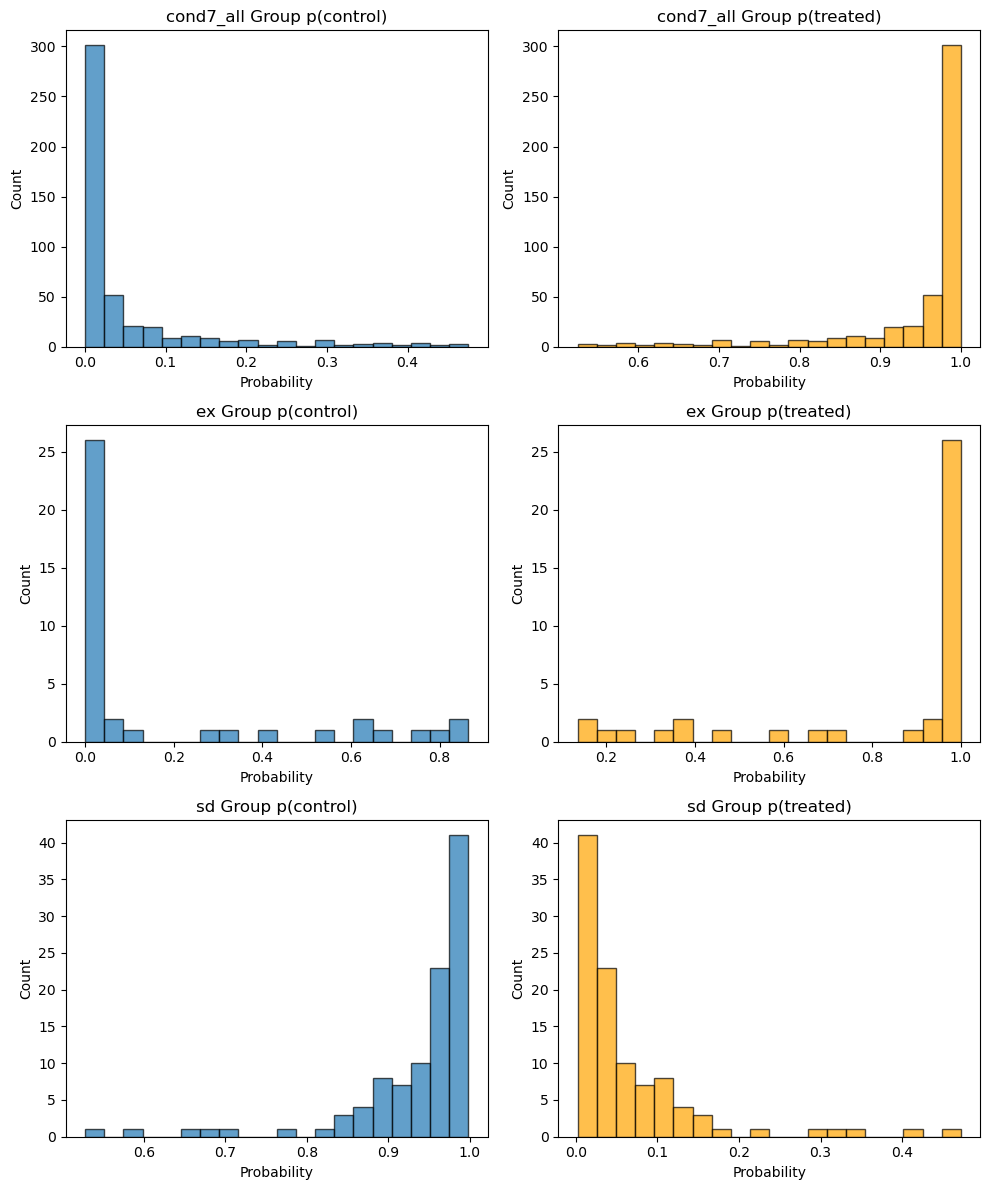

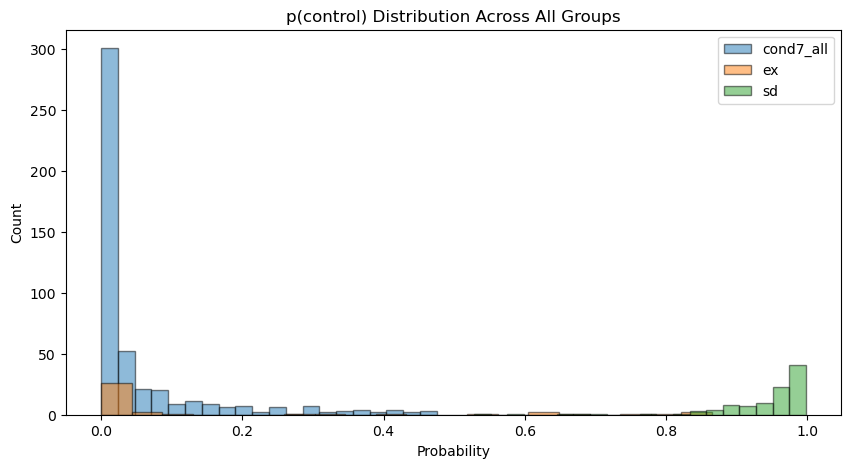

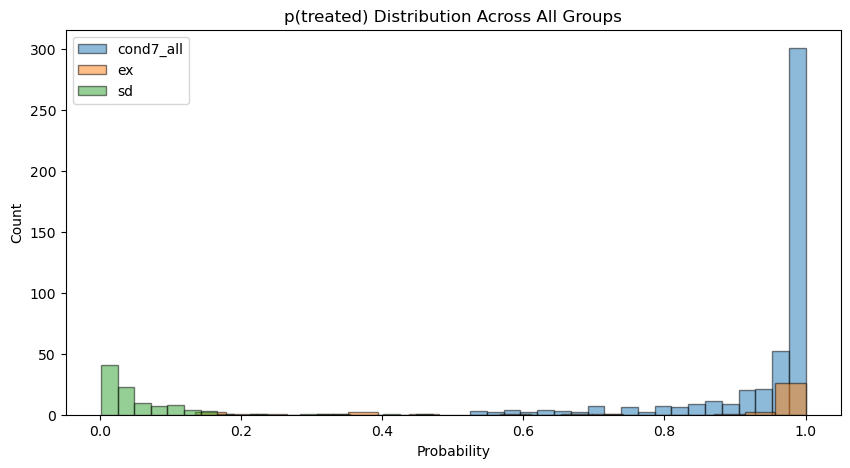

In [26]:
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

In [27]:
all_images_data = []
for grp in groups:
    # each entry is [p_control, p_treated, img_path]
    all_images_data.extend(groups_data[grp])

# Sort by p(treated) in ascending order
all_images_data.sort(key=lambda x: x[1])  # No reverse=True

# Now all_images_data is sorted by p(treated) in ascending ordergroups_data[group_name]
sorted_by_treated = [(entry[2], entry[1]) for entry in all_images_data]

print("Images sorted by p(treated) in ascending order:")
for img_path, p_tr in sorted_by_treated:
    print(f"{img_path}: {p_tr:.4f}")

Images sorted by p(treated) in ascending order:
G:\softmax\inference\sd\RBT10_C09-T01.tiff: 0.0020
G:\softmax\inference\sd\RBT10_B11-T01.tiff: 0.0024
G:\softmax\inference\sd\RBT10_E09-T01.tiff: 0.0032
G:\softmax\inference\sd\RBT09_C07-T01.tiff: 0.0046
G:\softmax\inference\sd\RBT10_B07-T01.tiff: 0.0063
G:\softmax\inference\sd\RBT14_B08-T01.tiff: 0.0075
G:\softmax\inference\sd\RBT10_F10-T01.tiff: 0.0079
G:\softmax\inference\sd\RBT10_B08-T01.tiff: 0.0084
G:\softmax\inference\sd\RBT09_D08-T01.tiff: 0.0084
G:\softmax\inference\sd\RBT04_E09-T01.tiff: 0.0085
G:\softmax\inference\sd\RBT09_G10-T01.tiff: 0.0087
G:\softmax\inference\sd\RBT09_B10-T01.tiff: 0.0088
G:\softmax\inference\sd\RBT04_F08-T01.tiff: 0.0089
G:\softmax\inference\sd\RBT04_C09-T01.tiff: 0.0089
G:\softmax\inference\sd\RBT10_C11-T01.tiff: 0.0091
G:\softmax\inference\sd\RBT10_E10-T01.tiff: 0.0093
G:\softmax\inference\sd\RBT10_D08-T01.tiff: 0.0100
G:\softmax\inference\sd\RBT09_B07-T01.tiff: 0.0103
G:\softmax\inference\sd\RBT09_E09-

In [28]:
def calculate_custom_accuracy(groups_data):
    """
    Calculate custom accuracy with group name tracking.
    
    Parameters:
    groups_data : dict
        Dictionary with group names as keys and lists of [p_control, p_treated, path] as values
    
    Returns:
    float: Calculated accuracy
    dict: Detailed accuracy metrics
    """
    # Extract probabilities and group names
    group_names = list(groups_data.keys())
    class_probabilities = [
        [item[1] for item in groups_data[group]]  # p_treated probabilities
        for group in group_names
    ]
    
    # Calculate means for each group
    class_means = [np.mean(probs) for probs in class_probabilities]
    
    # Sort means with corresponding group names
    sorted_means = sorted(zip(group_names, class_means), key=lambda x: x[1])
    
    # Identify middle, first, and third classes
    first_class_name = sorted_means[0][0]
    middle_class_name = sorted_means[1][0]
    third_class_name = sorted_means[2][0]
    
    # Rest of the calculation remains the same as previous implementation
    middle_class_index = group_names.index(middle_class_name)
    
    # Find min and max of middle class
    middle_class_probs = class_probabilities[middle_class_index]
    middle_class_min = min(middle_class_probs)
    middle_class_max = max(middle_class_probs)
    
    # Error Calculation
    first_class_index = group_names.index(first_class_name)
    third_class_index = group_names.index(third_class_name)
    
    first_class_errors = sum(1 for prob in class_probabilities[first_class_index] 
                              if prob > middle_class_min)
    
    third_class_errors = sum(1 for prob in class_probabilities[third_class_index] 
                              if prob < middle_class_max)
    
    # Total points and total errors
    total_points = sum(len(probs) for probs in class_probabilities)
    total_errors = first_class_errors + third_class_errors
    
    # Accuracy calculation
    accuracy = (total_points - total_errors) / total_points
    
    # Print class information
    print(f"First class according to mean: {first_class_name}")
    print(f"Middle class according to mean: {middle_class_name}")
    print(f"Third class according to mean: {third_class_name}")
    
    return accuracy, {
        'group_names': group_names,
        'class_means': dict(zip(group_names, class_means)),
        'middle_class_name': middle_class_name,
        'middle_class_min': middle_class_min,
        'middle_class_max': middle_class_max,
        'first_class_errors': first_class_errors,
        'third_class_errors': third_class_errors,
        'total_points': total_points,
        'total_errors': total_errors
    }

# Simplified usage
def apply_accuracy_calculation(groups_data):
    """
    Apply accuracy calculation to the groups data.
    
    Parameters:
    groups_data : dict
        Dictionary with group names as keys and lists of [p_control, p_treated, path] as values
    
    Returns:
    float: Calculated accuracy
    """
    accuracy, metrics = calculate_custom_accuracy(groups_data)
    
    print(f"\nCalculated Accuracy: {accuracy:.4f}")
    print("\nDetailed Metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value}")
    
    return accuracy

In [29]:
print(apply_accuracy_calculation(groups_data))

First class according to mean: sd
Middle class according to mean: ex
Third class according to mean: cond7_all

Calculated Accuracy: 0.2163

Detailed Metrics:
group_names: ['cond7_all', 'ex', 'sd']
class_means: {'cond7_all': 0.9478729, 'ex': 0.8222515, 'sd': 0.06539266}
middle_class_name: ex
middle_class_min: 0.1352544128894806
middle_class_max: 0.999998927116394
first_class_errors: 10
third_class_errors: 472
total_points: 615
total_errors: 482
0.216260162601626
